# **Logistic Regression**

<a href="https://colab.research.google.com/drive/1QRBnZAm2XXmpBqHD-nOKvrXs9GZxWUSA#scrollTo=XJGshRge0ylO" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ลองทดลองเพิ่ม จาก link ตัวอย่าง
https://blog.quantinsti.com/machine-learning-logistic-regression-python/

In [ ]:
!pip install ta
!pip install pandas_ta

**Import The Libraries**

In [ ]:
# Import library
import ta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_ta as ta

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# Data fetching
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

**Import The Data**

Nifty >> from 2010 to 2023.

Let us print the top five rows of column ‘Open’, ‘High’, ‘Low’, ‘Close’.

In [ ]:
#Import Data Test Nifty >> from 2010 to 2023
df = pdr.get_data_yahoo('^NSEI', '2010-01-01', '2023-01-01')
df = df.dropna()
df = df.iloc[:,:4]
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195
2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902
2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805
2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098
2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000


**Define Predictor/Independent Variables**

กำหนดตัวแปร

In [ ]:
# คำนวณค่าเฉลี่ยเคลื่อนที่ในระยะ 10 วัน (10-day moving average) ของราคาปิด (Close) และเก็บผลลัพธ์ในคอลัมน์ 'S_10'.
df['S_10'] = df['Close'].rolling(window=10).mean()

# คำนวณความสัมพันธ์ (correlation) ระหว่างราคาปิด (Close) และค่าเฉลี่ยเคลื่อนที่ในระยะ 10 วัน ('S_10') และเก็บผลลัพธ์ในคอลัมน์ 'Corr'.
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])

# คำนวณค่าดัชนีความเเข็งแข็งสัมพันธ์ (Relative Strength Index, RSI) ในระยะ 10 วัน โดยใช้ pandas_ta และเก็บผลลัพธ์ในคอลัมน์ 'RSI'.
df['RSI'] = df.ta.rsi(length=10)

# คำนวณความแตกต่างระหว่างราคาเปิด (Open) และราคาปิด (Close) แล้วเก็บผลลัพธ์ในคอลัมน์ 'Open-Close'.
df['Open-Close'] = df['Open'] - df['Close'].shift(1)

# คำนวณความแตกต่างระหว่างราคาปิด (Close) ของวันก่อนหน้าและราคาเปิด (Open) ของวันปัจจุบัน แล้วเก็บผลลัพธ์ในคอลัมน์ 'Open-Open'.
df['Open-Open'] = df['Close'].shift(1) - df['Open']

# ลบแถวที่มีค่า NaN (ข้อมูลที่หายไป) ออกจาก DataFrame.
df = df.dropna()

# เลือกคุณสมบัติ (features) ที่จะนำไปใช้ในการวิเคราะห์หรือโมเดลเช่น 'S_10', 'Corr', 'RSI', 'Open-Close', 'Open-Open', 'Open', 'High', 'Low', และ 'Close' และเก็บในตัวแปร X.
X = df[['S_10', 'Corr', 'RSI', 'Open-Close', 'Open-Open', 'Open', 'High', 'Low', 'Close']]

# แสดง DataFrame
print(X.head())


                   S_10      Corr        RSI  Open-Close  Open-Open  \
Date                                                                  
2010-01-29  5071.485010  0.924392  17.081988   -1.100098   1.100098   
2010-02-01  5036.235010  0.875205  21.252887    0.000000   0.000000   
2010-02-02  4991.760010  0.865243  17.414818    8.149902  -8.149902   
2010-02-03  4962.380029  0.749618  36.145994    0.899902  -0.899902   
2010-02-04  4924.745020  0.721059  29.768392   -0.550293   0.550293   

                   Open         High          Low        Close  
Date                                                            
2010-01-29  4866.149902  4893.700195  4766.000000  4882.049805  
2010-02-01  4882.049805  4918.799805  4827.149902  4899.700195  
2010-02-02  4907.850098  4951.149902  4814.100098  4830.100098  
2010-02-03  4831.000000  4949.149902  4831.000000  4931.850098  
2010-02-04  4931.299805  4931.299805  4832.350098  4845.350098  


**Define Target/Dependent Variable**

กำหนดเป้าหมาย/ตัวแปรตาม

In [ ]:
y = np.where(df['Close'].shift(-1) > df['Close'],1,-1)

**Split The Dataset**

แยกชุดข้อมูล : แบ่งชุดข้อมูลออกเป็นชุดข้อมูลการฝึกอบรมและชุดข้อมูลทดสอบ เราจะใช้ข้อมูลของเรา 70% ในการฝึกอบรม และอีก 20% ที่เหลือเพื่อทดสอบ ในการดำเนินการนี้ เราจะสร้างตัวแปรแยกซึ่งจะแบ่งกรอบข้อมูลเป็นอัตราส่วน 70:30 'X train' และ 'Y train' เป็นชุดข้อมูลรถไฟ 'X test' และ 'Y test' เป็นชุดข้อมูลทดสอบ

In [ ]:
split = int(0.7*len(df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]


**Instantiate The Logistic Regression in Python**

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate the model
model = DecisionTreeClassifier()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict using the trained model
y_pred = model.predict(X_test)


In [ ]:
# Import library
import pandas as pd

# สร้าง DataFrame เพื่อเก็บค่า Feature Importance ของโมเดล
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})

# แสดงค่า Feature Importance ที่ได้จากโมเดล
print(feature_importance)


      Feature  Importance
0        S_10    0.103359
1        Corr    0.179532
2         RSI    0.179142
3  Open-Close    0.115726
4   Open-Open    0.104286
5        Open    0.090835
6        High    0.071795
7         Low    0.069030
8       Close    0.086294


**Predict Class Labels**

In [ ]:
probability = model.predict_proba(X_test)
print(probability)

predicted = model.predict(X_test)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


**Evaluate The Model**

Confusion Matrix

In [ ]:
print(metrics.confusion_matrix(y_test, predicted))

[[257 177]
 [291 227]]


**Classification Report**

In [ ]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

          -1       0.47      0.59      0.52       434
           1       0.56      0.44      0.49       518

    accuracy                           0.51       952
   macro avg       0.52      0.52      0.51       952
weighted avg       0.52      0.51      0.51       952



**Model Accuracy**

In [ ]:
print(model.score(X_test,y_test))

0.5084033613445378


**Cross-Validation**

In [ ]:
cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(cross_val)
print(cross_val.mean())

[0.51886792 0.52996845 0.52365931 0.53943218 0.55205047 0.51735016
 0.5362776  0.47949527 0.52365931 0.51419558]
0.5234956252604012


**Create Trading Strategy Using The Model**

<ipython-input-15-acac54204ee1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Predicted_Signal'] = model.predict(X)
<ipython-input-15-acac54204ee1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Nifty_returns'] = np.log(df['Close']/df['Close'].shift(1))
<ipython-input-15-acac54204ee1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

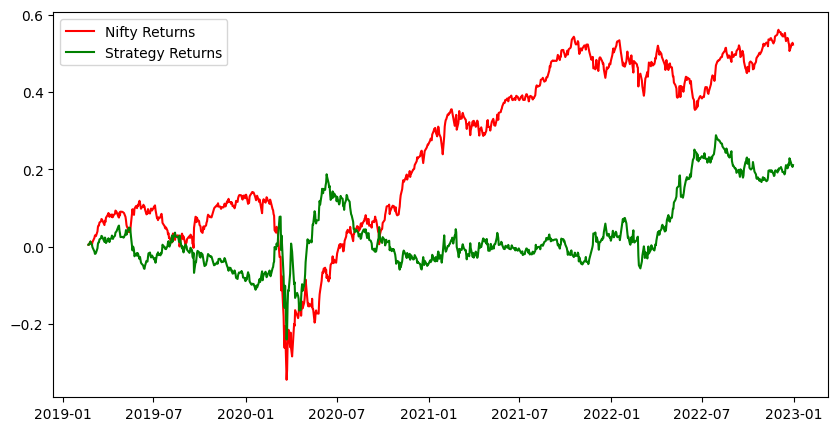

In [ ]:
df['Predicted_Signal'] = model.predict(X)
df['Nifty_returns'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_Nifty_returns = np.cumsum(df[split:]['Nifty_returns'])

df['Startegy_returns'] = df['Nifty_returns']* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(df[split:]['Startegy_returns'])

plt.figure(figsize=(10,5))
plt.plot(Cumulative_Nifty_returns, color='r',label = 'Nifty Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()